In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime as dt
%matplotlib inline
import os
import sys 
from tqdm import tqdm


sys.path.append('/home/drdarby/Desktop/cape_mend_SM_LCS/datatools')
import datatools as tools
import cmocean as cm
import gsw
from scipy.interpolate import griddata
import xgcm
print(xgcm.__path__)

['/home/drdarby/miniconda3/envs/mitgcm/lib/python3.11/site-packages/xgcm']


### Getting points from the 270

In [2]:
path_llc270 = '/media/drdarby/Elements/data/llc270/'
grid_files, grid_filepaths = tools.get_data_paths_from_binary(path_llc270, 'Grid', file_end = 'nc' )
grid_270 = xr.open_mfdataset(grid_filepaths[6])
grid_270 = grid_270.rename({'i1':'k','i2':'j','i3':'i'})
grid_270['i'] = (grid_270['i']-1).astype(int)
grid_270['j'] = (grid_270['j']-1).astype(int)
grid_270['k'] = (grid_270['k'] -1).astype(int)

In [3]:
x_left=np.linspace(0,23,50)
x_right = np.linspace(102,150,70)
y_left = ((150-200)/60)*x_left+200
y_right =((190-150)/80)*x_right+118


i_corr_left = x_left#.round().astype('int')
j_corr_left = ((150-200)/55)*i_corr_left+200
j_corr_left = j_corr_left#.round().astype('int')
i_per_1 = np.linspace(23,34,500).astype('int')
j_per_1 = ((160-180)/10)*i_per_1+225
i_per_2 = np.linspace(34,60,50)
j_per_2 = ((150-160)/35)*i_per_2+167
i_per_3 =np.linspace(60,90,50)
j_per_3 = ((175-150)/68)*i_per_3+128

i_corr_right = x_right#.round().astype('int')

j_corr_right =((190-150)/80)*i_corr_right+119
j_corr_right = j_corr_right#.round().astype('int')

i_final = np.linspace(90,102,50)
j_final = (11/15)*i_final+95

In [5]:
transect_i = np.concatenate([i_corr_left,i_per_1,i_per_2,i_per_3,i_final,i_corr_right])
transect_j = np.concatenate([j_corr_left,j_per_1,j_per_2,j_per_3,j_final,j_corr_right])

i,j = np.meshgrid(np.array(grid.i),np.array(grid.j))


points_tuple = [] 
for k in range(0,len(transect_i)):
    absi = np.abs(i-transect_i[k])
    absj = np.abs(j-transect_j[k])
    c = np.maximum(absi, absj)
    ind = np.unravel_index(np.argmin(np.array(c), axis=None),c.shape)
    points_tuple.append(ind)

points_i = []
points_j = []
for h in range(0,len(list(dict.fromkeys(points_tuple)))):
    tups = list(dict.fromkeys(points_tuple))[h]
    points_i.append(tups[1])
    points_j.append(tups[0])

In [6]:
points_j_corr =  np.interp(np.array(grid.isel(i=slice(0,150)).i),points_i,points_j)
points_i_corr = np.array(grid.isel(i=slice(0,150)).i)

In [ ]:
depth_of_shelf =[]
for l in range(0,len(points_j_corr)):
    selection = depth.isel(i=slice(0,150)).sel(j=slice(145,220))[:,l].where(depth.j>points_j_corr[l])
    depth_of_shelf.append(np.array(selection))

In [ ]:
shelf_mask_270 = np.isfinite(np.array(depth_of_shelf).T)

### Translating the 270 shelf points to 1080

In [7]:
grid_filepath = '/media/drdarby/Elements/data/L1_llc1080/L1_N_Greenland_grid.nc'
grid = xr.open_dataset(grid_filepath)

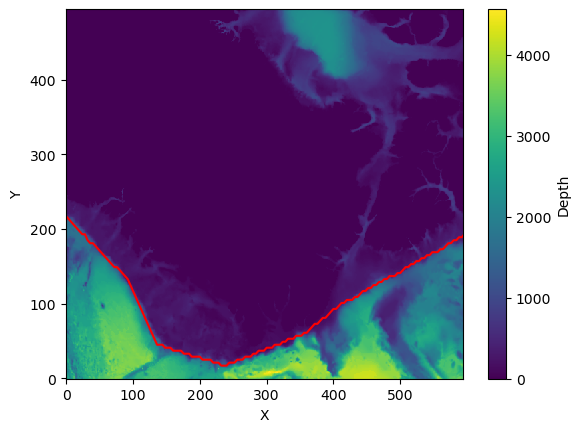

In [42]:
grid.Depth.sel(X=slice(0,150*4-6),Y=slice(145*4-355,270*4-355)).plot()
plt.plot(points_i_corr*4,points_j_corr*4-356-227,'r')

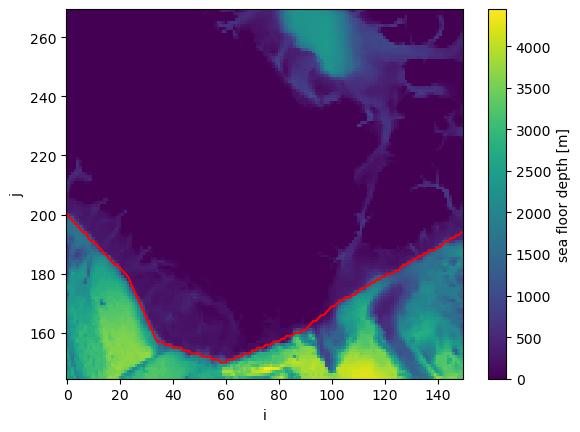

In [23]:
depth = grid_270.Depth.isel(i=slice(0,150),j=slice(145,270)).plot()
plt.plot(points_i_corr,points_j_corr,'r')

In [47]:
points_X = points_i_corr*4
points_Y = points_j_corr*4-356-227

In [50]:
points_Y_corr =  np.interp(np.array(grid.Depth.sel(X=slice(0,150*4-6),Y=slice(145*4-355,270*4-355)).X),points_X,points_Y)
points_X_corr = np.array(grid.Depth.sel(X=slice(0,150*4-6),Y=slice(145*4-355,270*4-355)).X)

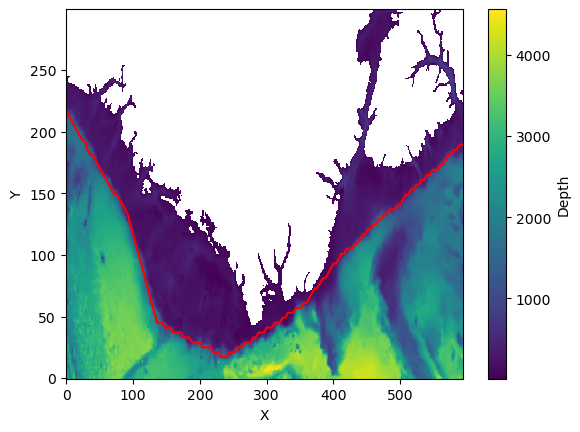

In [129]:
depth =grid.Depth.where(grid.Depth>0)

depth.sel(X=slice(0,150*4-6),Y=slice(145*4-355,270*4-355)).sel(Y=slice(0,300)).plot()
plt.plot(points_X_corr,points_Y_corr,'r')

### Subsample variables

In [102]:
llc1080_path = '/media/drdarby/Elements/data/N_Greenland/solution_output/heat_budget/'
var = ['ADVx_TH','ADVy_TH','DFxE_TH','DFyE_TH','KPPg_TH']
llc1080_ts_path = '/media/drdarby/Elements/data/N_Greenland/solution_output/'
ts_files, ts_filepath = tools.get_data_paths_from_binary(llc1080_ts_path,'llc_1080',file_end='nc')

ADVx_TH_files , ADVx_TH_filepaths = tools.get_data_paths_from_binary(llc1080_path,var[0],file_end='nc')
ADVy_TH_files, ADVy_TH_filepaths = tools.get_data_paths_from_binary(llc1080_path,var[1],file_end='nc')
DFxE_TH_files, DFxE_TH_filepaths = tools.get_data_paths_from_binary(llc1080_path,var[2],file_end='nc')
DFyE_TH_files, DFyE_TH_filepaths = tools.get_data_paths_from_binary(llc1080_path,var[3],file_end='nc')
KPPg_TH_files, KPPg_TH_filepaths = tools.get_data_paths_from_binary(llc1080_path,var[4],file_end='nc')

ADVx_TH = xr.open_mfdataset(ADVx_TH_filepaths).rename({'rows':'Y','cols':'X'}).sel(X=slice(0,594),Y=slice(145*4-355,270*4-355))['ADVx_TH']
ADVy_TH = xr.open_mfdataset(ADVy_TH_filepaths).rename({'rows':'Y','cols':'X'}).sel(X=slice(0,594),Y=slice(145*4-355,270*4-355))['ADVy_TH']
DFxE_TH = xr.open_mfdataset(DFxE_TH_filepaths).rename({'rows':'Y','cols':'X'}).sel(X=slice(0,594),Y=slice(145*4-355,270*4-355))['DFxE_TH']
DFyE_TH = xr.open_mfdataset(DFyE_TH_filepaths).rename({'rows':'Y','cols':'X'}).sel(X=slice(0,594),Y=slice(145*4-355,270*4-355))['DFyE_TH']
KPPg_TH = xr.open_mfdataset(KPPg_TH_filepaths).rename({'rows':'Y','cols':'X'}).sel(X=slice(0,594),Y=slice(145*4-355,270*4-355))['KPPg_TH']
TS = xr.open_mfdataset(ts_filepath).rename({'rows':'Y','cols':'X'}).sel(X=slice(0,594),Y=slice(145*4-355,270*4-355))

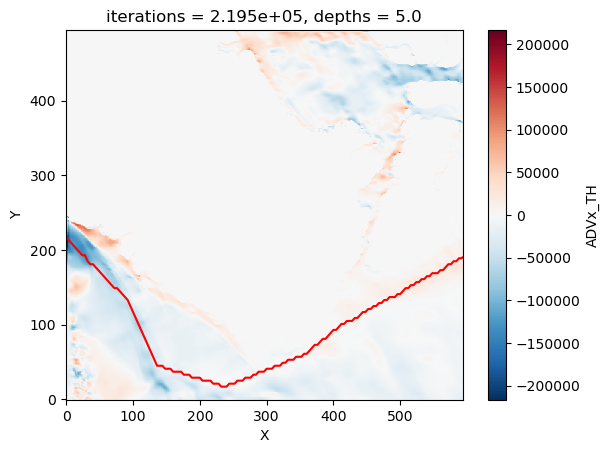

In [103]:
#test point selection on a variable
ADVx_TH.isel(X=slice(0,594),iterations=0,depths=0).plot()
plt.plot(points_X_corr,points_Y_corr,'r')

In [104]:
ADVx_TH.sel(X=slice(0,594))

<xarray.DataArray 'ADVx_TH' (iterations: 324, depths: 50, Y: 495, X: 594)>
dask.array<getitem, shape=(324, 50, 495, 594), dtype=float32, chunksize=(12, 50, 495, 594), chunktype=numpy.ndarray>
Coordinates:
  * iterations  (iterations) float32 2.195e+05 2.275e+05 ... 3.042e+06 3.051e+06
  * depths      (depths) float32 5.0 15.0 25.0 ... 5.039e+03 5.461e+03 5.906e+03
Dimensions without coordinates: Y, X

In [106]:
#convert data to usable time
sec_itr_1080 = 300
def date_to_iter_number(date,seconds_per_iter = 60):

    total_seconds = (date-datetime(1992,1,1)).total_seconds()
    iter_number = total_seconds/seconds_per_iter
    # print(iter_number)
    return(iter_number)

def iter_number_to_date(iter_number,seconds_per_iter=60):

    total_seconds = iter_number*seconds_per_iter
    date = datetime(1992,1,1) + timedelta(seconds=total_seconds)
    # print(date)
    return(date)
time = []

for i in range(0,len(TS.iterations)):
    t_date = iter_number_to_date(np.array(TS.iterations)[i],seconds_per_iter=sec_itr_1080)
    time.append(t_date)
time_sub = []


for i in range(0,len(ADVx_TH.iterations)):
    t_date = iter_number_to_date(np.array(ADVx_TH.iterations)[i],seconds_per_iter=sec_itr_1080)
    time_sub.append(t_date)

In [107]:
ADVx_TH.coords['iterations'] = np.array(time_sub)
ADVy_TH.coords['iterations'] = np.array(time_sub)
DFxE_TH.coords['iterations'] = np.array(time_sub)
DFyE_TH.coords['iterations'] = np.array(time_sub)
KPPg_TH.coords['iterations'] = np.array(time_sub)

In [108]:
TS.coords['iterations'] = np.array(time)

In [112]:
TS = TS.drop_vars('time')

In [118]:
KPPg_TH.time


<xarray.DataArray 'time' (time: 324)>
array(['1994-02-01T00:00:00.000000000', '1994-03-01T00:00:00.000000000',
       '1994-04-01T00:00:00.000000000', ..., '2020-11-01T00:00:00.000000000',
       '2020-12-01T00:00:00.000000000', '2021-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1994-02-01 1994-03-01 ... 2021-01-01

In [119]:
ADVx_TH = ADVx_TH.rename({'iterations':'time'})
ADVy_TH = ADVy_TH.rename({'iterations':'time'})
DFxE_TH = DFxE_TH.rename({'iterations':'time'})
DFyE_TH = DFyE_TH.rename({'iterations':'time'})
KPPg_TH = KPPg_TH.rename({'iterations':'time'})
TS = TS.rename({'iterations':'time'})

ValueError: cannot rename 'iterations' because it is not a variable or dimension in this dataset

In [120]:
TS = TS.sel(time=KPPg_TH.time)

In [122]:
KPPg_TH

<xarray.DataArray 'KPPg_TH' (time: 324, depths: 50, Y: 495, X: 594)>
dask.array<getitem, shape=(324, 50, 495, 594), dtype=float32, chunksize=(12, 50, 495, 594), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1994-02-01 1994-03-01 ... 2021-01-01
  * depths   (depths) float32 5.0 15.0 25.0 ... 5.039e+03 5.461e+03 5.906e+03
Dimensions without coordinates: Y, X

In [125]:
temp = TS['Theta']#.where(shelf_mask[1:,:])
salt = TS['Salt']
#subsample
X,Y = np.meshgrid(np.array(temp.X),np.array(temp.Y))
points = np.column_stack([np.ravel(X), np.ravel(Y)])
x = np.arange(len(points_X_corr))
for m in tqdm(range(0,len(ADVy_TH.time))):
    time = [np.array(ADVy_TH.time[m])]
    for n in range(0,len(ADVy_TH.depths)):
        k_num = [np.array(ADVy_TH.depths)[n]]
        sampled_transect_ADVy_TH = griddata(points, np.array(ADVy_TH.isel(time=m,depths=n)).ravel(), (points_X_corr, points_Y_corr),method='nearest')
        sampled_transect_ADVx_TH = griddata(points, np.array(ADVx_TH.isel(time=m,depths=n)).ravel(), (points_X_corr, points_Y_corr),method='nearest')
        sampled_transect_DFxE_TH = griddata(points, np.array(DFxE_TH.isel(time=m,depths=n)).ravel(), (points_X_corr, points_Y_corr),method='nearest')
        sampled_transect_DFyE_TH = griddata(points, np.array(DFyE_TH.isel(time=m,depths=n)).ravel(), (points_X_corr, points_Y_corr),method='nearest')
        sampled_transect_KPPg_TH = griddata(points, np.array(KPPg_TH.isel(time=m,depths=n)).ravel(), (points_X_corr, points_Y_corr),method='nearest')

        sampled_transect_THETA = griddata(points, np.array(temp.isel(time=m,depths=n)).ravel(), (points_X_corr, points_Y_corr),method='nearest')
        sampled_transect_SALT = griddata(points, np.array(salt.isel(time=m,depths=n)).ravel(), (points_X_corr, points_Y_corr),method='nearest')

        sampled_transect_ADVy_TH = np.reshape(sampled_transect_ADVy_TH, (1,1,len(points_X_corr)))
        sampled_transect_ADVx_TH = np.reshape(sampled_transect_ADVx_TH, (1,1,len(points_X_corr)))
        sampled_transect_DFxE_TH = np.reshape(sampled_transect_DFxE_TH, (1,1,len(points_X_corr)))
        sampled_transect_DFyE_TH = np.reshape(sampled_transect_DFyE_TH, (1,1,len(points_X_corr)))
        sampled_transect_KPPg_TH = np.reshape(sampled_transect_KPPg_TH, (1,1,len(points_X_corr)))
        sampled_transect_SALT = np.reshape(sampled_transect_SALT, (1,1,len(points_X_corr)))
        sampled_transect_THETA = np.reshape(sampled_transect_THETA, (1,1,len(points_X_corr)))
        
        advy_data = xr.DataArray(sampled_transect_ADVy_TH ,coords=[time,k_num,x],dims=['time','depths','x'],name='ADVy_TH')
        advx_data = xr.DataArray(sampled_transect_ADVx_TH,coords=[time,k_num,x],dims=['time','depths','x'],name='ADVx_TH')
        difx_data = xr.DataArray(sampled_transect_DFxE_TH ,coords=[time,k_num,x],dims=['time','depths','x'],name='DFxE_TH')
        dify_data = xr.DataArray(sampled_transect_DFyE_TH ,coords=[time,k_num,x],dims=['time','depths','x'],name='DFyE_TH')
        kpp_data = xr.DataArray(sampled_transect_KPPg_TH ,coords=[time,k_num,x],dims=['time','depths','x'],name='KPPg_TH')
        salt_data = xr.DataArray(sampled_transect_SALT ,coords=[time,k_num,x],dims=['time','depths','x'],name='SALT')
        temp_data = xr.DataArray(sampled_transect_THETA ,coords=[time,k_num,x],dims=['time','depths','x'],name='THETA')

        advy_data.to_netcdf(llc1080_ts_path+'shelf-subsample/ADVy_TH/ADVy_TH_'+str(m).zfill(4)+'_'+str(n).zfill(2)+'.nc')
        advx_data.to_netcdf(llc1080_ts_path+'shelf-subsample/ADVx_TH/ADVx_TH_'+str(m).zfill(4)+'_'+str(n).zfill(2)+'.nc')
        difx_data.to_netcdf(llc1080_ts_path+'shelf-subsample/DFxE_TH/DFxE_TH_'+str(m).zfill(4)+'_'+str(n).zfill(2)+'.nc')
        dify_data.to_netcdf(llc1080_ts_path+'shelf-subsample/DFyE_TH/DFyE_TH_'+str(m).zfill(4)+'_'+str(n).zfill(2)+'.nc')
        kpp_data.to_netcdf(llc1080_ts_path+'shelf-subsample/KPPg_TH/KPPg_TH _'+str(m).zfill(4)+'_'+str(n).zfill(2)+'.nc')
        salt_data.to_netcdf(llc1080_ts_path+'shelf-subsample/SALT/SALT_'+str(m).zfill(4)+'_'+str(n).zfill(2)+'.nc')
        temp_data.to_netcdf(llc1080_ts_path+'shelf-subsample/THETA/THETA_'+str(m).zfill(4)+'_'+str(n).zfill(2)+'.nc')


100%|███████████████████████████████████████| 324/324 [3:55:27<00:00, 43.60s/it]


In [152]:
ADVy_TH_tran_files, ADVy_TH_tran_filepaths = tools.get_data_paths_from_binary(llc1080_ts_path, 'shelf-subsample/ADVy_TH', file_end = 'nc' )
ADVx_TH_tran_files, ADVx_TH_tran_filepaths = tools.get_data_paths_from_binary(llc1080_ts_path, 'shelf-subsample/ADVx_TH', file_end = 'nc' )
DFxE_TH_tran_files, DFxE_TH_tran_filepaths = tools.get_data_paths_from_binary(llc1080_ts_path, 'shelf-subsample/DFxE_TH', file_end = 'nc' )
DFyE_TH_tran_files, DFyE_TH_tran_filepaths = tools.get_data_paths_from_binary(llc1080_ts_path, 'shelf-subsample/DFyE_TH', file_end = 'nc' )
KPPg_TH_tran_files, KPPg_TH_tran_filepaths = tools.get_data_paths_from_binary(llc1080_ts_path, 'shelf-subsample/KPPg_TH', file_end = 'nc' )


In [153]:
ADVy_TH_tran = xr.open_mfdataset(ADVy_TH_tran_filepaths)
ADVx_TH_tran = xr.open_mfdataset(ADVx_TH_tran_filepaths)
DFxE_TH_tran = xr.open_mfdataset(DFxE_TH_tran_filepaths)
DFyE_TH_tran = xr.open_mfdataset(DFyE_TH_tran_filepaths)
KPPg_TH_tran = xr.open_mfdataset(KPPg_TH_tran_filepaths)

In [154]:
time = np.array(ADVy_TH_tran.time)

In [155]:
ADVy_TH_tran.coords['time'] = time
DFyE_TH_tran.coords['time'] = time
DFxE_TH_tran.coords['time'] = time
ADVx_TH_tran.coords['time'] = time
KPPg_TH_tran.coords['time'] = time

In [156]:
ADVy_TH_tran.to_netcdf(llc1080_ts_path+'shelf-subsample/adv_y_N_shelf.nc')

In [157]:
DFyE_TH_tran.to_netcdf(llc1080_ts_path+'shelf-subsample/dif_y_N_shelf.nc')

In [158]:
DFxE_TH_tran.to_netcdf(llc1080_ts_path+'shelf-subsample/dif_x_N_shelf.nc')

In [159]:
ADVx_TH_tran.to_netcdf(llc1080_ts_path+'shelf-subsample/adv_x_N_shelf.nc')

In [160]:
KPPg_TH_tran.to_netcdf(llc1080_ts_path+'shelf-subsample/kpp_N_shelf.nc')

In [161]:
adv_files, adv_filepaths = tools.get_data_paths_from_binary(llc1080_ts_path, 'shelf-subsample/', file_end = 'nc' )
adv = xr.open_mfdataset(adv_filepaths)

In [164]:
correct_flux = np.ones(np.shape(ADVx_TH_tran['ADVx_TH']))
correct_flux[:,:,232:] = -1
correct_flux[:,:,(points_Y_corr==17.)] = 0
#correct_flux[:,:,points_Y_corr<17.] = -1

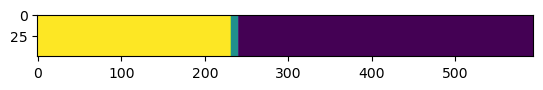

<xarray.DataArray 'ADVx_TH' (time: 324, depths: 50, x: 594)>
dask.array<concatenate, shape=(324, 50, 594), dtype=float32, chunksize=(1, 1, 594), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1994-02-01 1994-03-01 ... 2021-01-01
  * depths   (depths) float32 5.0 15.0 25.0 ... 5.039e+03 5.461e+03 5.906e+03
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 585 586 587 588 589 590 591 592 593

### Shelf content

In [139]:

depth_of_shelf =[]
for l in range(0,len(points_X_corr)):
    selection = depth.sel(X=slice(0,150*4-6),Y=slice(145*4-355,270*4-355)).sel(Y=slice(0,300))[:,l].where(depth.sel(X=slice(0,150*4-6),Y=slice(145*4-355,270*4-355)).sel(Y=slice(0,300)).Y>=points_Y_corr[l])
    depth_of_shelf.append(np.array(selection))

In [169]:
x = np.arange(len(points_X_corr))
sampled_transect_depth = griddata(points, np.array(grid['Depth'].sel(X=slice(0,594),Y=slice(145*4-355,270*4-355))).ravel(), (points_X_corr, points_Y_corr),method='nearest')
#sampled_transect_depth = np.reshape(sampled_transect_ADVy_TH, (1,1,len(points_i_corr)))
depth_data = xr.DataArray(sampled_transect_depth ,coords=[x],dims=['x'],name='bathy')

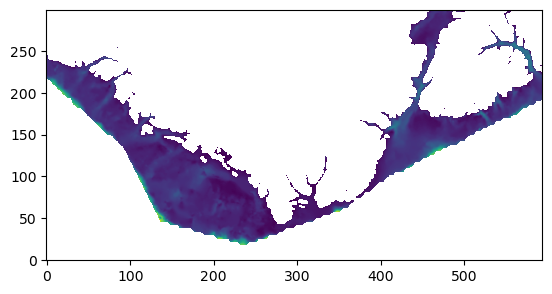

In [178]:
plt.imshow(np.array(depth_of_shelf).T)
plt.gca().invert_yaxis()


<xarray.DataArray 'depths' (depths: 50)>
array([5.000000e+00, 1.500000e+01, 2.500000e+01, 3.500000e+01, 4.500000e+01,
       5.500000e+01, 6.500000e+01, 7.500500e+01, 8.502500e+01, 9.509500e+01,
       1.053100e+02, 1.158700e+02, 1.271500e+02, 1.397400e+02, 1.544700e+02,
       1.724000e+02, 1.947350e+02, 2.227100e+02, 2.574700e+02, 2.999300e+02,
       3.506800e+02, 4.099300e+02, 4.774700e+02, 5.527100e+02, 6.347350e+02,
       7.224000e+02, 8.144701e+02, 9.097401e+02, 1.007155e+03, 1.105905e+03,
       1.205535e+03, 1.306205e+03, 1.409150e+03, 1.517095e+03, 1.634175e+03,
       1.765135e+03, 1.914150e+03, 2.084035e+03, 2.276225e+03, 2.491250e+03,
       2.729250e+03, 2.990250e+03, 3.274250e+03, 3.581250e+03, 3.911250e+03,
       4.264250e+03, 4.640250e+03, 5.039250e+03, 5.461250e+03, 5.906250e+03],
      dtype=float32)
Coordinates:
  * depths   (depths) float32 5.0 15.0 25.0 ... 5.039e+03 5.461e+03 5.906e+03

In [226]:
shelf_mask = np.isfinite(np.array(depth_of_shelf).T)
temp_cont = temp.sel(Y=slice(0,300)).where(temp.depths>200)#.where(shelf_mask[1:,:])
salt_cont = salt.sel(Y=slice(0,300)).where(temp.depths>200)#.where(shelf_mask[1:,:])
heat_1080 = gsw.cp_t_exact(temp_cont, salt_cont, temp_cont.sel(X=slice(0,150*4-6),Y=slice(145*4-355,270*4-355)).depths).rename('heat_1080').where(temp.depths>0).sel(Y=slice(0,300))

/home/drdarby/miniconda3/envs/mitgcm/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in cp_t_exact
  return func(*(_execute_task(a, cache) for a in args))


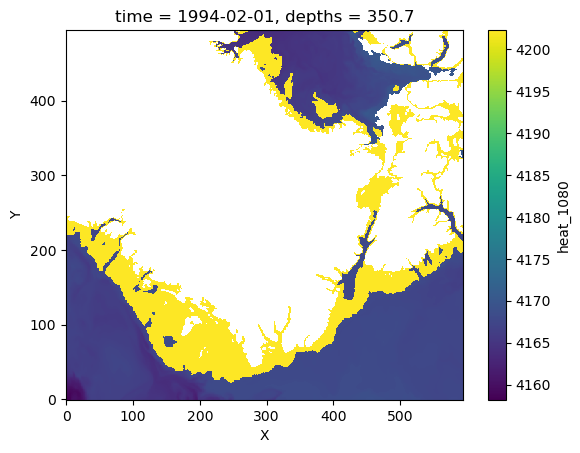

In [224]:
heat_1080.isel(time=0,depths=20).where(depth.sel(X=slice(0,150*4-6),Y=slice(145*4-355,270*4-355))>0).plot()

In [225]:
for m in tqdm(range(0,len(ADVy_TH.time))):
    time = [np.array(ADVy_TH.time[m])]
    for n in range(0,len(ADVy_TH.depths)):
        k_num = [np.array(ADVy_TH.depths)[n]]
        sampled_transect_heat = griddata(points, np.array(heat_1080.isel(time=m,depths=n)).ravel(), (points_X_corr, points_Y_corr),method='nearest')
        sampled_transect_heat = np.reshape(sampled_transect_ADVy_TH, (1,1,len(points_X_corr)))
        heat_data = xr.DataArray(sampled_transect_heat ,coords=[time,k_num,x],dims=['time','depths','x'],name='heat')
        heat_data.to_netcdf(llc1080_ts_path+'shelf-subsample/heat/heat_'+str(m).zfill(4)+'_'+str(n).zfill(2)+'.nc')

  0%|                                                   | 0/324 [00:00<?, ?it/s]/home/drdarby/miniconda3/envs/mitgcm/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in cp_t_exact
  return func(*(_execute_task(a, cache) for a in args))
/home/drdarby/miniconda3/envs/mitgcm/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in cp_t_exact
  return func(*(_execute_task(a, cache) for a in args))
/home/drdarby/miniconda3/envs/mitgcm/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in cp_t_exact
  return func(*(_execute_task(a, cache) for a in args))
/home/drdarby/miniconda3/envs/mitgcm/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in cp_t_exact
  return func(*(_execute_task(a, cache) for a in args))
/home/drdarby/miniconda3/envs/mitgcm/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in cp_t_ex

KeyboardInterrupt: 

In [232]:
heat_1080 = gsw.cp_t_exact(temp_cont, salt_cont, temp_cont.sel(X=slice(0,150*4-6),Y=slice(145*4-355,270*4-355)).sel(Y=slice(0,300)).depths).rename('heat_1080')

/home/drdarby/miniconda3/envs/mitgcm/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in cp_t_exact
  return func(*(_execute_task(a, cache) for a in args))


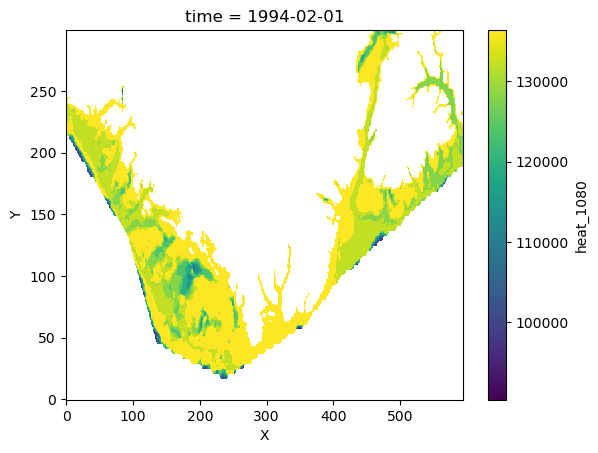

In [233]:
heat_1080.isel(time=0).sum(dim='depths',skipna=True).where(shelf_mask[:,:]).plot()

In [190]:
np.shape(heat_1080)

(324, 50, 300, 594)

### final

/home/drdarby/miniconda3/envs/mitgcm/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in cp_t_exact
  return func(*(_execute_task(a, cache) for a in args))


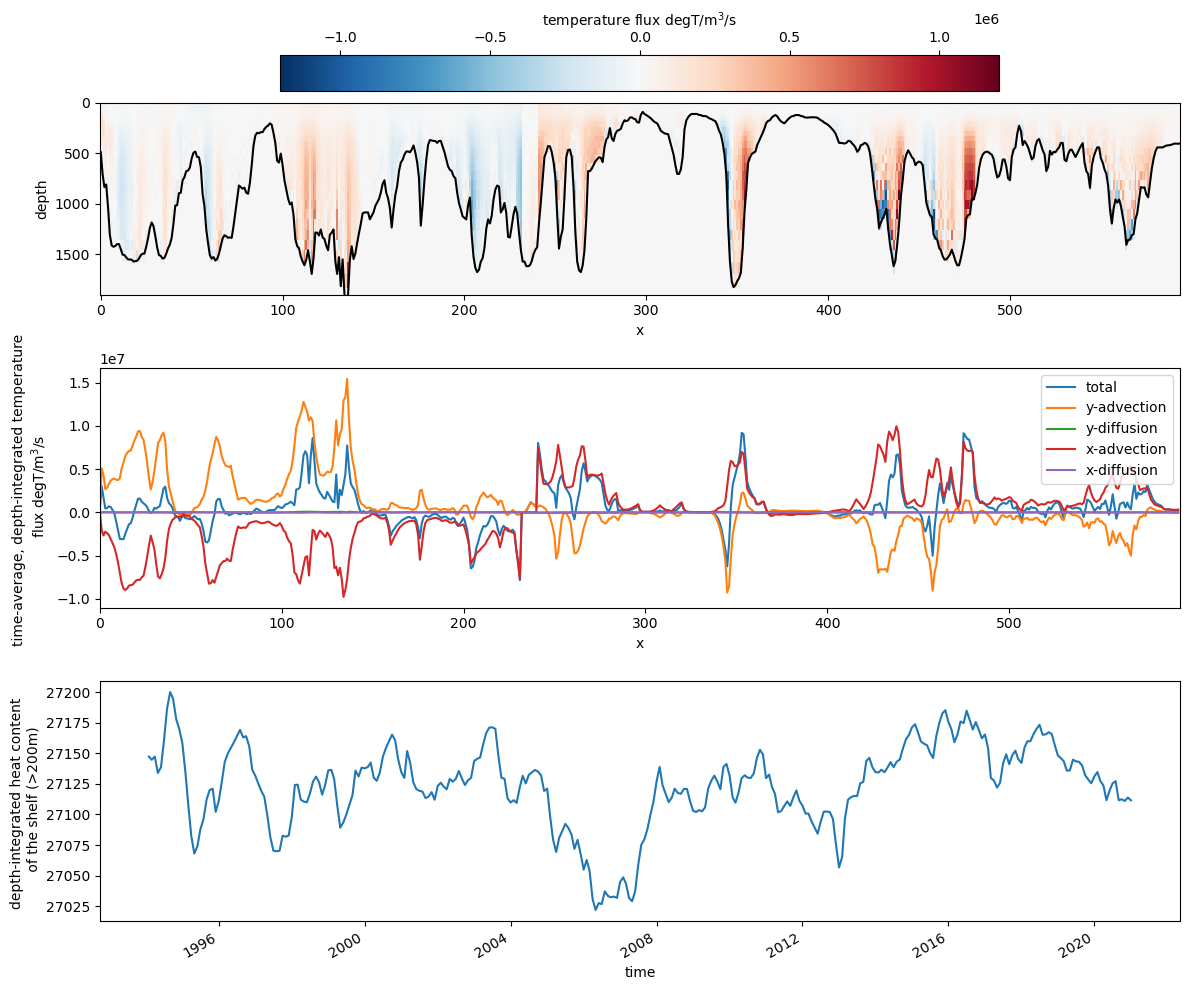

In [235]:
fig,ax = plt.subplots(ncols=1, nrows=3,figsize=(12,10))

(adv['ADVy_TH']+adv['DFyE_TH']+adv['ADVx_TH']*correct_flux + adv['DFxE_TH']*correct_flux).mean(dim='time',skipna=True).plot(y='depths',ax=ax[0],cbar_kwargs={'location':'top','label':'temperature flux degT/m$^3$/s'})
ax[0].plot(x,np.array(depth_data),'black')
plt.tight_layout()
(adv['ADVy_TH']+adv['DFyE_TH']+adv['ADVx_TH']*correct_flux + adv['DFxE_TH']*correct_flux).sum(dim='depths',skipna=True).mean(dim='time',skipna=True).plot(ax=ax[1],label='total')
adv['ADVy_TH'].sum(dim='depths',skipna=True).mean(dim='time',skipna=True).plot(ax=ax[1],label='y-advection')
adv['DFyE_TH'].sum(dim='depths',skipna=True).mean(dim='time',skipna=True).plot(ax=ax[1],label='y-diffusion')
(adv['ADVx_TH']*correct_flux).sum(dim='depths',skipna=True).mean(dim='time',skipna=True).plot(ax=ax[1],label='x-advection')
(adv['DFxE_TH']*correct_flux).sum(dim='depths',skipna=True).mean(dim='time',skipna=True).plot(ax=ax[1],label='x-diffusion')
ax[1].legend()
ax[1].set_ylabel('time-average, depth-integrated temperature \n flux degT/m$^3$/s')
heat_1080.where(shelf_mask[:,:]).sum(dim='depths',skipna=True).mean(dim='X',skipna=True).mean(dim='Y',skipna=True).plot(ax=ax[2])
ax[0].set_ylabel('depth')
ax[2].set_ylabel('depth-integrated heat content \n of the shelf (>200m)')
ax[1].set_xlim(0,594)

ax[0].set_ylim(1900,0)
ax[2].set_title('')
plt.tight_layout()

In [171]:
adv

<xarray.Dataset>
Dimensions:  (time: 324, depths: 50, x: 594)
Coordinates:
  * time     (time) datetime64[ns] 1994-02-01 1994-03-01 ... 2021-01-01
  * depths   (depths) float32 5.0 15.0 25.0 ... 5.039e+03 5.461e+03 5.906e+03
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 585 586 587 588 589 590 591 592 593
Data variables:
    ADVx_TH  (time, depths, x) float32 dask.array<chunksize=(324, 50, 594), meta=np.ndarray>
    ADVy_TH  (time, depths, x) float32 dask.array<chunksize=(324, 50, 594), meta=np.ndarray>
    DFxE_TH  (time, depths, x) float32 dask.array<chunksize=(324, 50, 594), meta=np.ndarray>
    DFyE_TH  (time, depths, x) float32 dask.array<chunksize=(324, 50, 594), meta=np.ndarray>
    KPPg_TH  (time, depths, x) float32 dask.array<chunksize=(324, 50, 594), meta=np.ndarray>